# Constrained Clustering Example with PCKMeans

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from scipy import spatial as sdist
import copy
from sklearn.metrics import pairwise_distances, adjusted_rand_score
import time
import itertools
import random
from sklearn.cluster import KMeans
import matplotlib.lines as mlines

In [2]:
def l2_distance(point1, point2):
    return sum([(float(i) - float(j)) ** 2 for (i, j) in zip(point1, point2)])

def tolerance(tol, dataset):
    n = len(dataset)
    dim = len(dataset[0])
    averages = [sum(dataset[i][d] for i in range(n)) / float(n) for d in range(dim)]
    variances = [sum((dataset[i][d] - averages[d]) ** 2 for i in range(n)) / float(n) for d in range(dim)]
    return tol * sum(variances) / dim

def PCKMeans(x, k, const_mat, weighted = False, tol=1e-4, max_iter = 20000, init_centroids = []):

    #n = number of instances / d = number of features
    n, d = np.shape(x)

    tol = tolerance(tol, x)
    
    #Initialize centroids
    if len(init_centroids) == 0:

        centroids = np.random.rand(k, d)

        for i in range(k):
            centroids[i, :] = centroids[i, :] + np.min(x, 0)
    else:
        centroids = init_centroids

    start_time = time.time()
    #Get maximally separated instances
    max_distance = np.power(np.max(x, axis = 0) - np.min(x, axis = 0), 2)

    #Initialize partition
    partition = np.ones(n) * -1

    iters = 0

    while iters < max_iter:

        iters += 1

        #Assign each instance to its closest cluster centroid
        for i in range(n):

            instance = x[i,:]

            #Compute squared euclidean distances
            squared_diffs = np.sum(np.power(centroids - instance, 2), axis = 1)

            #Compute penalties
            penalties = np.zeros(k)

            for l in range(k):

                for j in range(n):

                    #if the second instance has a label
                    if partition[j] != -1:

                        #if ML(i,j) and instance i is going to be assigned to a label other than the label of instance j
                        if const_mat[i,j] == 1 and l != partition[j]:

                            if weighted:

                                penalties[l] += np.sum(np.power(instance - x[j,:], 2))
                            else:

                                penalties[l] += 1

                        #if ML(i,j) and instance i is going to be assigned to a label equal to the label of instance j
                        if const_mat[i,j] == -1 and l == partition[j]:

                            if weighted:

                                penalties[l] += np.sum((max_distance - np.power(instance - x[j,:], 2)))

                            else:

                                penalties[l] += 1

            partition[i] = np.argmin((squared_diffs + penalties)/2)

        #Recompute centroids
        old_centroids = copy.deepcopy(centroids)
        for i in range(k):

            cluster = x[np.where(partition == i)[0],:]
            if cluster.shape[0] > 0:
                centroids[i,:] = np.mean(cluster, axis = 0)
        
        #Compute centroid shift for stopping criteria
        shift = sum(l2_distance(centroids[i], old_centroids[i]) for i in range(k))
        #Alternative stopping criteria
        if shift <= tol:
            break

    return partition, iters, time.time() - start_time

def gen_rand_const(labels, nb_const, random_state = 42):
    random.seed(random_state)
    pairs = np.array(list(itertools.combinations(range(0, len(labels)), 2)))
    ind = random.sample(range(0, len(pairs)), nb_const)
    const = pairs[ind]

    const_matrix = np.identity(len(labels))

    for i in const:

        if labels[i[0]] == labels[i[1]]:

            const_matrix[i[0], i[1]] = 1
            const_matrix[i[1], i[0]] = 1

        else:

            const_matrix[i[0], i[1]] = -1
            const_matrix[i[1], i[0]] = -1

    return const_matrix

def plot_constraints_3D(plot_3D, constraints, dataset):
    
    for i in range(constraints.shape[0]):
        
        for j in range(i):
            
            if constraints[i,j] == 1:
                
                plot_3D.plot([X[i,0],X[j,0]],[X[i,1],X[j,1]],[X[i,2],X[j,2]], color='black')
                
            if constraints[i,j] == -1:
                
                plot_3D.plot([X[i,0],X[j,0]],[X[i,1],X[j,1]],[X[i,2],X[j,2]], color='black', linestyle="--")
    
    return plot_3D

def plot_constraints_2D(plot_2D, constraints, dataset):
    
    for i in range(constraints.shape[0]):
        
        for j in range(i):
            
            if constraints[i,j] == 1:
                
                plot_2D.plot([X[i,0],X[j,0]],[X[i,1],X[j,1]], color='black')
                
            if constraints[i,j] == -1:
                
                plot_2D.plot([X[i,0],X[j,0]],[X[i,1],X[j,1]], color='black', linestyle="--")
    
    return plot_2D

def generate_data_2D(centers, sigmas, numb_data, random_state = 42):
    
    np.random.seed(random_state)
    xpts = np.zeros(1)
    ypts = np.zeros(1)
    labels = np.zeros(1)
    for i, ((xmu, ymu), (xsigma, ysigma)) in enumerate(zip(centers, sigmas)):
        xpts = np.hstack((xpts, np.random.standard_normal(numb_data) * xsigma + xmu))
        ypts = np.hstack((ypts, np.random.standard_normal(numb_data) * ysigma + ymu))
        labels = np.hstack((labels, np.ones(numb_data) * i))

    X = np.zeros((len(xpts) - 1, 2))
    X[:, 0] = xpts[1:]
    X[:, 1] = ypts[1:]

    y = labels[1:]

    return X, y

([], [])

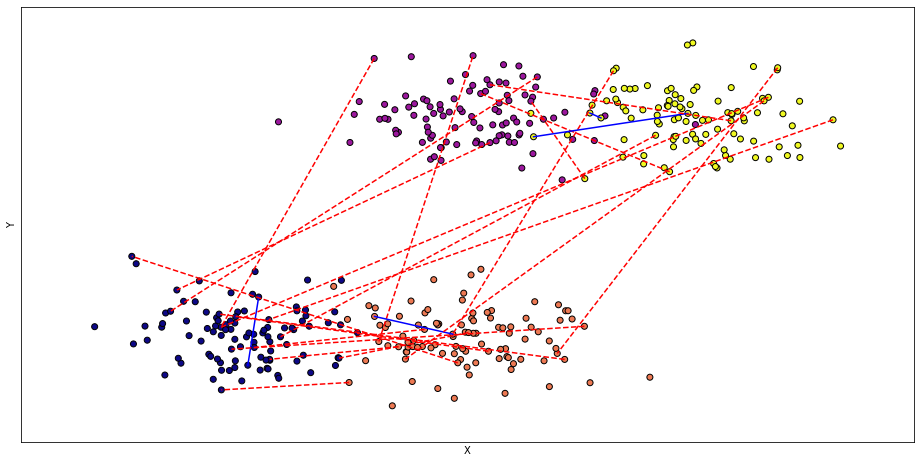

In [3]:
# Generate and plot a toy dataset to experiment with Classic Clustering and Constrained Clustering
#Set centers and sigmas for every blob in the toy dataset (sigma refers to the scattering of the cluster)
centers = [(1,1),(2.5,4),(2.5,1),(4,4)]
sigmas = [(.4,.4),(.4,.4),(.4,.4),(.4,.4)]
#Generate datasets and labels
X, y = generate_data_2D(centers, sigmas, 100)
#Generate a random set of constraints
constraints = gen_rand_const(y,25)

#Set plot parameters
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

plot_2D = plt.figure(2,figsize=(16, 8))
plot_2D.clf()

#Plot constraints over the toy dataset
for i in range(constraints.shape[0]):
        
        for j in range(i):
            
            #ML constraints are marked with solid lines
            if constraints[i,j] == 1:
                
                plt.plot([X[i,0],X[j,0]],[X[i,1],X[j,1]], color='blue')
            
            #CL constraints are marked with dashed lines
            if constraints[i,j] == -1:
                
                plt.plot([X[i,0],X[j,0]],[X[i,1],X[j,1]], color='red', linestyle="--")

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.plasma, edgecolor="k")
plt.xlabel("X")
plt.ylabel("Y")

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

/Users/salvadorgarcialopez/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


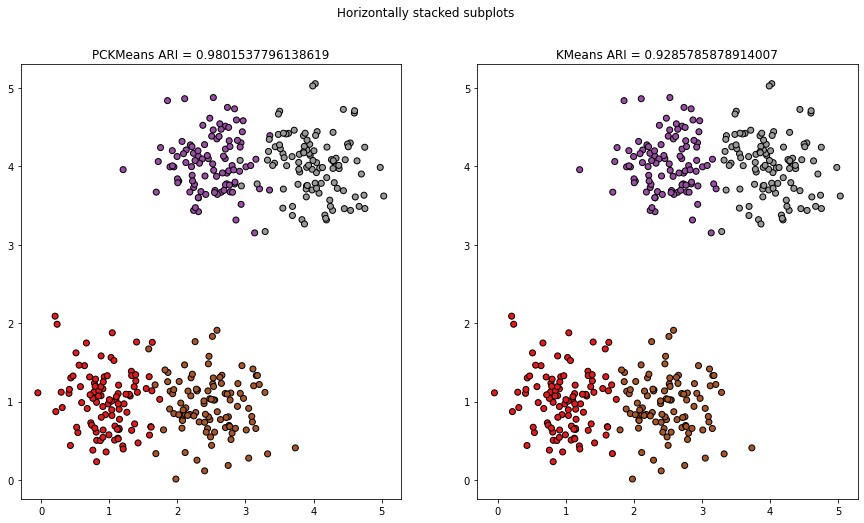

In [4]:
#Generate a larger constraint set (for us to be able to observe their influence)
constraints = gen_rand_const(y,1000)
#Perform PCK-Means with stable centroids over the toy dataset
predicted_pckm, iters, runtime = PCKMeans(X, 4, constraints, weighted = False, tol=1e-4, max_iter = 20000, init_centroids = np.array([[1,1],[2.5,4],[2.5,1],[4,4]]))
#Perform K-Means over the toy dataset
predicted_km = KMeans(n_clusters = 4, random_state = 42, init = np.array([[1,1],[2.5,4],[2.5,1],[4,4]])).fit(X).labels_ 

#Set plot parameters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
fig.suptitle('Horizontally stacked subplots')

#Plot PCK-Means results with the obtained ARI value
ax1.scatter(X[:, 0], X[:, 1], c=predicted_pckm, cmap=plt.cm.Set1, edgecolor="k")
ax1.title.set_text('PCKMeans ARI = ' + str(adjusted_rand_score(y, predicted_pckm)))
#Plot K-Means results with the obtained ARI value
ax2.scatter(X[:, 0], X[:, 1], c=predicted_km, cmap=plt.cm.Set1, edgecolor="k")
ax2.title.set_text('KMeans ARI = ' + str(adjusted_rand_score(y, predicted_km)))

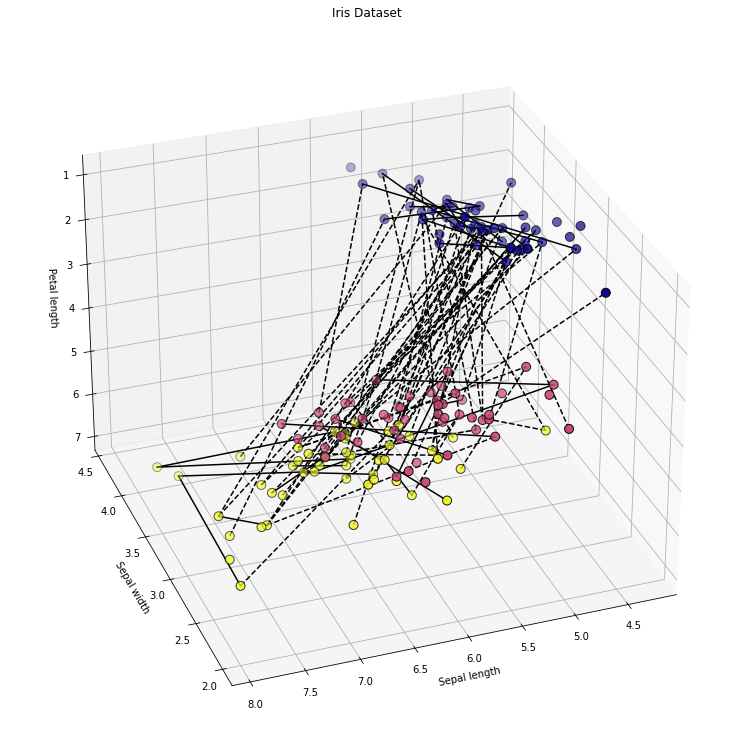

In [9]:
# Import and plot the iris dataset with a constraint set
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Plot the iris dataset in 3D
fig = plt.figure(1, figsize=(15, 10))
ax = Axes3D(fig, elev=-150, azim=110,auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter(
    X[:, 0],
    X[:, 1],
    X[:, 2],
    c=y,
    cmap=plt.cm.plasma,
    edgecolor="k",
    s=80,
)
ax.set_title("Iris Dataset")
ax.set_xlabel("Sepal length")
ax.set_ylabel("Sepal width")
ax.set_zlabel("Petal length")

#Generate and draw a small constraint set
constraints = gen_rand_const(y, 100)
ax = plot_constraints_3D(ax, constraints, X)

In [10]:
# Perform classic K-Means and PCK-Means over the iris dataset with increasing levels of constraint-based information,
# initializing PCK-Means with the centroids obtained by K-Means
km_results = KMeans(n_clusters = 3, random_state = 42).fit(X)
predicted_km = km_results.labels_
centroids_km = km_results.cluster_centers_
ari_km = adjusted_rand_score(y, predicted_km)
ari_values_pckm = []
ari_values_km = []

for i in range(0, 1000, 10):
    constraints = gen_rand_const(y, i)
    predicted_pckm, iters, runtime = PCKMeans(X, 3, constraints, weighted = False, tol=1e-4, max_iter = 20000, init_centroids = centroids_km)
    ari_values_pckm.append([i, adjusted_rand_score(y, predicted_pckm)])
    ari_values_km.append([i, ari_km])

ari_values_pckm = np.array(ari_values_pckm)
ari_values_km = np.array(ari_values_km)

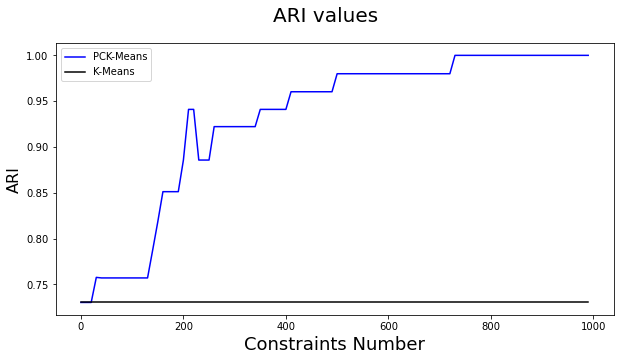

In [11]:
# Plot and compare the results obtained by K-Means and PCK-Means
ari_plot, ax = plt.subplots(figsize=(10,5))
plt.plot(ari_values_pckm[:, 0], ari_values_pckm[:, 1], c='blue')
plt.plot(ari_values_km[:, 0], ari_values_km[:, 1], c='black')

ari_plot.suptitle('ARI values', fontsize=20)
plt.xlabel('Constraints Number', fontsize=18)
plt.ylabel('ARI', fontsize=16)

blue_line = mlines.Line2D([], [], color='blue', markersize=15, label='PCK-Means')
black_line = mlines.Line2D([], [], color='black', markersize=15, label='K-Means')
ax.legend(handles=[blue_line, black_line])

plt.show()